In [1]:
# basic packages
import pandas as pd
import numpy as np
import warnings

# visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from plotly import graph_objs as go
from plotly.graph_objs import *

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

from sklearn.metrics import mean_absolute_error as MAE
from scipy.stats import skew

%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')

In [52]:
# importing saved data
df = pd.read_csv('./data/processed/combined.csv')

df['starttime'] = pd.to_datetime(df['starttime'], format = '%Y-%m-%d %H:%M')
df['stoptime'] = pd.to_datetime(df['stoptime'], format = '%Y-%m-%d %H:%M')

df = df.set_index('starttime')
df.head()

,tripduration,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan
starttime,,,,,,,,,,,,,,,
2013-12-24 15:50:04,1780,2013-12-24 16:19:44,439,E 4 St & 2 Ave,40.726281,-73.989780,271,Ashland Pl & Hanson Pl,40.685282,-73.978058,17993,Subscriber,1951.0,male,NaN
2013-11-18 18:32:00,646,2013-11-18 18:42:46,79,Franklin St & W Broadway,40.719116,-74.006667,3002,South End Ave & Liberty St,40.711512,-74.015756,16337,Subscriber,1945.0,male,NaN
2013-08-20 07:42:02,664,2013-08-20 07:53:06,352,W 56 St & 6 Ave,40.763406,-73.977225,477,W 41 St & 8 Ave,40.756405,-73.990026,19632,Subscriber,1950.0,male,NaN
2013-11-21 13:26:07,166,2013-11-21 13:28:53,195,Liberty St & Broadway,40.709056,-74.010434,316,Fulton St & William St,40.709560,-74.006536,20065,Subscriber,1951.0,male,NaN
2013-09-01 12:16:59,587,2013-09-01 12:26:46,363,West Thames St,40.708347,-74.017134,147,Greenwich St & Warren St,40.715422,-74.011220,17095,Subscriber,1952.0,male,NaN


In [116]:
# reading in precipitation data
description = pd.read_csv('./data/weather/weather_description.csv')[['datetime', 'New York']]
description['datetime'] = description['datetime'].apply(lambda x: pd.Timestamp(x))
description = description.set_index(['datetime'])


# creating indicator if column contains keywords
des = list(description['New York'].unique()[1:])
keywords = ['rain', 'snow', 'drizzle', 'storm', 'mist']
indicies = [i for i, x in enumerate(list(des)) if any(y in x for y in keywords)]
precip_list = [des[i] for i in indicies]

# converting to bool, taking daily average and rounding up to indicate if there was preip at any point during day
description['precip'] = description['New York'].apply(lambda x: x in precip_list) * 1
description = description[['precip']].groupby(description.index.date).mean()
description['precip_bool'] = np.ceil(description.precip)
# description = description.reset_index().rename(columns = {'index' :'ds'})
# description['ds'] = pd.to_datetime(description['ds'])

In [117]:
# reading in temp data 
temp = pd.read_csv('./data/weather/temperature.csv')[['datetime', 'New York']]
temp['datetime'] = temp['datetime'].apply(lambda x: pd.Timestamp(x))
temp = temp.set_index(['datetime'])


# calculating daily averages
temp = temp.groupby(temp.index.date).mean().dropna()
temp = temp.rename(columns = {'New York' : 'temp'})


# converting kelvin to farenheit
temp['temp'] = (temp['temp'] - 273.15) * 9/5 + 32
# temp = temp.reset_index().rename(columns = {'index' : 'ds'})
# temp['ds'] = pd.to_datetime(temp['ds'])

In [118]:
# reading in wind data 
wind = pd.read_csv('./data/weather/wind_speed.csv')[['datetime', 'New York']]
wind['datetime'] = wind['datetime'].apply(lambda x: pd.Timestamp(x))
wind = wind.set_index(['datetime'])

# calculating daily averages
wind = wind.groupby(wind.index.date).mean().dropna()
wind = wind.rename(columns = {'New York' : 'wind'})
# wind = wind.reset_index().rename(columns = {'index' : 'ds'})
# wind['ds'] = pd.to_datetime(wind['ds'])
wind.head()

,wind
2012-10-01,6.363636
2012-10-02,4.833333
2012-10-03,2.416667
2012-10-04,1.875000
2012-10-05,1.375000


In [119]:
display(description.head(), temp.head(), wind.head())

,precip,precip_bool
2012-10-01,0.000000,0.0
2012-10-02,0.000000,0.0
2012-10-03,0.250000,1.0
2012-10-04,0.666667,1.0
2012-10-05,0.458333,1.0


,temp
2012-10-01,59.754956
2012-10-02,63.936300
2012-10-03,62.448125
2012-10-04,65.906750
2012-10-05,69.608375


,wind
2012-10-01,6.363636
2012-10-02,4.833333
2012-10-03,2.416667
2012-10-04,1.875000
2012-10-05,1.375000


In [170]:
# creating df for time series
df_fb = df[['tripduration']].groupby(df.index.date).count()
df_fb.index = pd.to_datetime(df_fb.index)
df_fb = df_fb.loc[:'2016-10', :]
df_fb = df_fb.rename(columns = {'tripduration' : 'y'})

# df_fb = df_fb.reset_index().rename(columns = {'index' : 'ds'})
df_fb.head()

,y
2013-07-01,1691
2013-07-02,2268
2013-07-03,2127
2013-07-04,2203
2013-07-05,2247


In [171]:
df_fb = df_fb.merge(temp, left_index = True, right_index = True, how = 'inner')
df_fb = df_fb.merge(description, left_index = True, right_index = True, how = 'inner')
df_fb = df_fb.merge(wind, left_index = True, right_index = True, how = 'inner')

In [172]:
df_fb.head()

,y,temp,precip,precip_bool,wind
2013-07-01,1691,75.603050,0.125000,1.0,2.916667
2013-07-02,2268,74.759375,0.458333,1.0,2.708333
2013-07-03,2127,76.584237,0.333333,1.0,3.000000
2013-07-04,2203,76.924700,0.333333,1.0,3.166667
2013-07-05,2247,81.244625,0.041667,1.0,3.166667


In [173]:
df_train = df_fb.loc[:'2015-09', :]
df_test = df_fb.loc['2015-10':, :]

In [174]:
df_train.reset_index(inplace = True)
df_train.rename(columns = {'index' : 'ds'}, inplace = True)
df_train.head()

,ds,y,temp,precip,precip_bool,wind
0,2013-07-01,1691,75.603050,0.125000,1.0,2.916667
1,2013-07-02,2268,74.759375,0.458333,1.0,2.708333
2,2013-07-03,2127,76.584237,0.333333,1.0,3.000000
3,2013-07-04,2203,76.924700,0.333333,1.0,3.166667
4,2013-07-05,2247,81.244625,0.041667,1.0,3.166667


In [175]:
df_test.reset_index(inplace = True)
df_test.rename(columns = {'index' : 'ds'}, inplace = True)
df_test.tail()

,ds,y,temp,precip,precip_bool,wind
356,2016-09-26,6160,59.321559,0.000,0.0,2.625000
357,2016-09-27,6288,68.280500,0.375,1.0,3.291667
358,2016-09-28,5903,62.483168,0.125,1.0,3.166667
359,2016-09-29,5554,60.525253,0.625,1.0,6.250000
360,2016-09-30,2128,58.944500,0.875,1.0,6.000000


In [176]:
del model

In [177]:
model = Prophet(mcmc_samples = 30, yearly_seasonality = 10, weekly_seasonality = True, changepoint_prior_scale = 0.1, seasonality_mode = 'multiplicative')

model.add_country_holidays(country_name = 'US')
model.add_regressor('temp', prior_scale = 0.5, mode = 'multiplicative')
model.add_regressor('precip', prior_scale = 0.5, mode = 'multiplicative')
model.add_regressor('wind', prior_scale = 0.5, mode = 'multiplicative')

model.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [178]:
future = model.make_future_dataframe(periods = df_test.shape[0], freq = '1D')
# future = future.merge(df_fb, on = 'ds', how = 'inner')
# future.drop(columns = ['y'], inplace = True)
future.head()

,ds
0,2013-07-01
1,2013-07-02
2,2013-07-03
3,2013-07-04
4,2013-07-05


In [179]:
future = future.merge(temp, left_on = 'ds', right_on = pd.to_datetime(temp.index), how = 'inner')
future = future.merge(description, left_on = 'ds', right_on = pd.to_datetime(description.index), how = 'inner')
future = future.merge(wind, left_on = 'ds', right_on = pd.to_datetime(wind.index), how = 'inner')

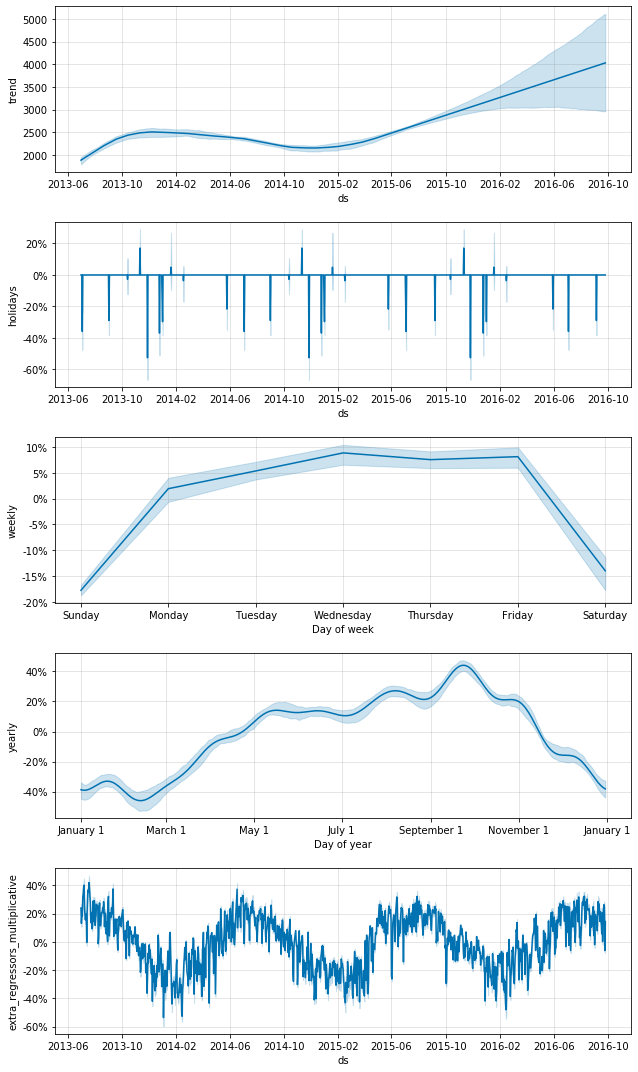

In [180]:
forecast = model.predict(future)
model.plot_components(forecast);

In [181]:
forecast.index = pd.to_datetime(forecast.ds)

df_train.index = pd.to_datetime(df_train.ds)
df_test.index = pd.to_datetime(df_test.ds)
data = pd.concat([df_train, df_test], axis=0)

forecast.loc[:,'y'] = data.loc[:,'y']

verif = forecast

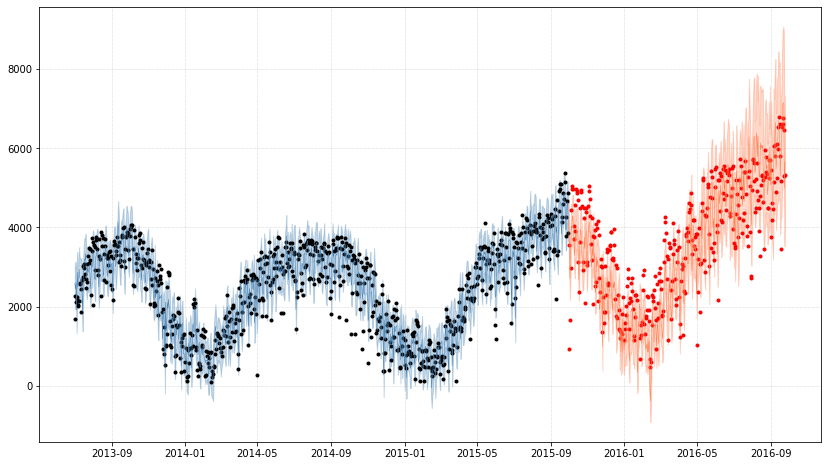

In [182]:
f, ax = plt.subplots(figsize=(14, 8))

train = verif.loc[:'2015-09',:]

ax.plot(train.index, train.y, 'ko', markersize=3)
ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)

test = verif.loc['2015-10':,:]

ax.plot(test.index, test.y, 'ro', markersize=3)
ax.plot(test.index, test.yhat, color='coral', lw=0.5)
ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)

# ax.axvline('2015-10', color='0.8', alpha=0.7)
ax.grid(ls=':', lw=0.5)

f;

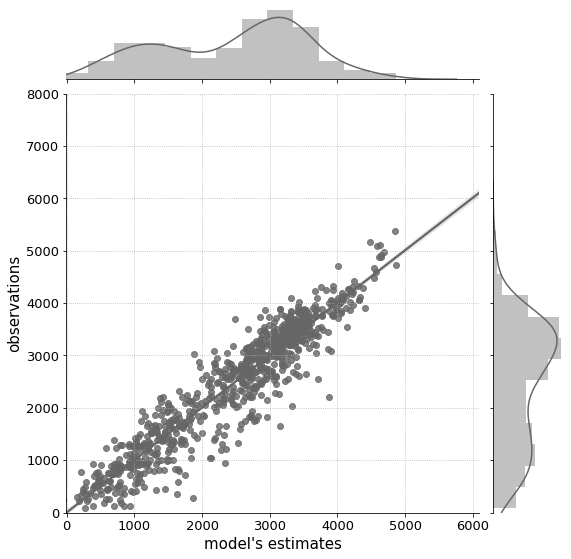

In [183]:
# train set 
g = sns.jointplot(x='yhat', y='y', data = verif.loc[:'2015-09',:], kind="reg", color="0.4")

g.fig.set_figwidth(8)
g.fig.set_figheight(8)

ax = g.fig.axes[1]

# if title is not None: 
#     ax.set_title(title, fontsize=16)

ax = g.fig.axes[0]

ax.set_xlim([-5, None])
ax.set_ylim([-5, 8000])

# ax.text(100, 2500, "R = {:+4.2f}\nMAE = {:4.1f}".format(verif.loc[:,['y','yhat']].corr().iloc[0,1], MAE(verif.loc[:,'y'].values, verif.loc[:,'yhat'].values)), fontsize=16)

ax.set_xlabel("model's estimates", fontsize=15)

ax.set_ylabel("observations", fontsize=15)

ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.grid(ls=':');

# if fname is not None: 
#     for ext in ['png','jpeg','pdf']: 
#         g.fig.savefig(os.path.join(fpath, "{}.{}".format(fname, ext)), dpi=200)

In [184]:
verif.loc[:'2015-09',['y','yhat']].corr()

,y,yhat
y,1.000000,0.940699
yhat,0.940699,1.000000


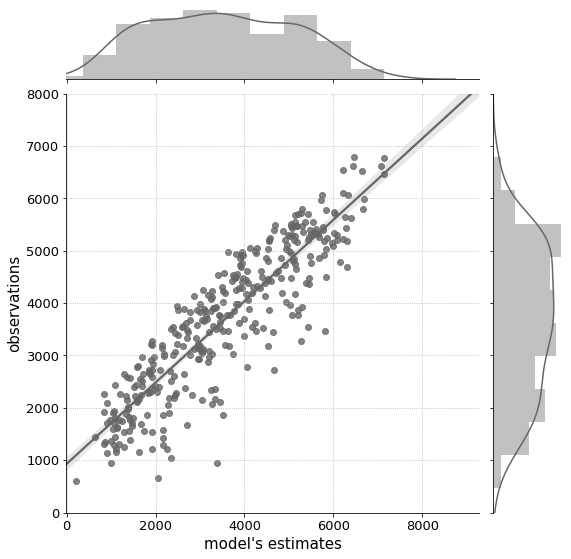

In [185]:
# train set 
g = sns.jointplot(x='yhat', y='y', data = verif.loc['2015-10':,:], kind="reg", color="0.4")

g.fig.set_figwidth(8)
g.fig.set_figheight(8)

ax = g.fig.axes[1]

# if title is not None: 
#     ax.set_title(title, fontsize=16)

ax = g.fig.axes[0]

ax.set_xlim([-5, None])
ax.set_ylim([-5, 8000])

# ax.text(100, 2500, "R = {:+4.2f}\nMAE = {:4.1f}".format(verif.loc[:,['y','yhat']].corr().iloc[0,1], MAE(verif.loc[:,'y'].values, verif.loc[:,'yhat'].values)), fontsize=16)

ax.set_xlabel("model's estimates", fontsize=15)

ax.set_ylabel("observations", fontsize=15)

ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.grid(ls=':');

# if fname is not None: 
#     for ext in ['png','jpeg','pdf']: 
#         g.fig.savefig(os.path.join(fpath, "{}.{}".format(fname, ext)), dpi=200)

In [186]:
verif.loc['2015-10':,['y','yhat']].corr()

,y,yhat
y,1.000000,0.893995
yhat,0.893995,1.000000


Text(0.5, 1.0, 'Residuals distribution (test set)')

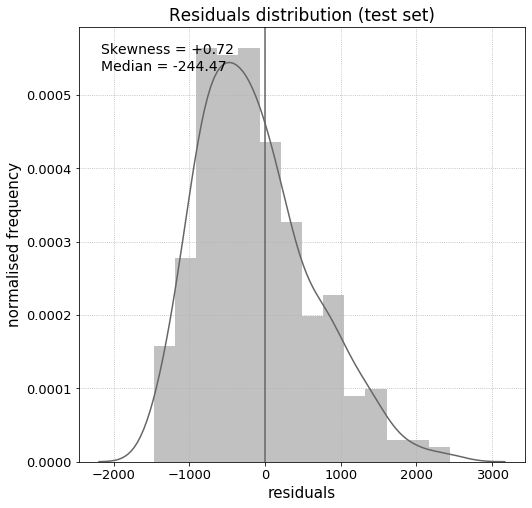

In [187]:
f, ax = plt.subplots(figsize=(8,8))
sns.distplot((verif.loc['2015-10':,'yhat'].fillna(0) - verif.loc['2015-10':,'y'].fillna(0)), ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.text(0.05, 0.9, "Skewness = {:+4.2f}\nMedian = {:+4.2f}".\
        format(skew(verif.loc['2015-10':,'yhat'].fillna(0) - verif.loc['2015-10':,'y'].fillna(0)), (verif.loc['2015-10':,'yhat'].fillna(0) - verif.loc['2015-10':,'y'].fillna(0)).median()), \
        fontsize=14, transform=ax.transAxes)

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (test set)', fontsize=17)